# simplot example

Code for *Modeling and Simulation in Python*

by Allen B. Downey, available from http://greenteapress.com

Copyright 2017 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np


In [2]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    If d is None, create a new dictionary.

    d: dictionary
    options: keyword args to add to d
    """
    if d is None:
        d = {}

    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [3]:
# TODO: move these definitions into simplot.py

def color_dict():
    return dict(b='blue', g='green', r='red', c='cyan', 
                m='magenta', y='yellow', k='black', w='white')

    # http://colorbrewer2.org/?type=qualitative&scheme=Set3&n=10
    return dict(b='#80b1d3', g='#b3de69', r='#fb8072', c='#8dd3c7', 
                m='#bc80bd', y='#fdb462', k='#696969', w='#d9d9d9')

def get_color(style, kwargs, d=color_dict()):
    color = kwargs.get('color')
    if color is not None:
        return color
    
    for key, value in d.items():
        if key in style:
            return value
    
    return '#80b1d3'

def get_key(style, kwargs):
    return style, kwargs.get('color')

In [4]:
class Simplot:
    
    def __init__(self):
        self.figure_states = dict()
        
    def get_figure_state(self, figure=None):
        if figure is None:
            figure = plt.gca()
        
        try:
            return self.figure_states[figure]
        except KeyError:
            figure_state = FigureState()
            self.figure_states[figure] = figure_state
            return figure_state
    
SIMPLOT = Simplot()

In [5]:
class FigureState:
    
    def __init__(self):
        self.lines = dict()
        
    def get_line(self, style, kwargs):
        key = get_key(style, kwargs)
        
        try:
            return self.lines[key]
        except KeyError:
            line = self.make_line(style, kwargs)
            self.lines[key] = line
            return line
    
    def make_line(self, style, kwargs):
        underride(kwargs, linewidth=2, alpha=0.6)
        lines = plt.plot([], style, **kwargs)
        return lines[0]

In [6]:
def plot(*args, **kwargs):
    x = None
    y = None
    style = 'bo-'
    
    if len(args) == 1:
        y = args[0]
    elif len(args) == 2:
        if isinstance(args[1], str):
            y, style = args
        else:
            x, y = args
    elif len(args) == 3:
        x, y, style = args
    
    figure = plt.gcf()
    figure_state = SIMPLOT.get_figure_state(figure)
    line = figure_state.get_line(style, kwargs)
    
    ys = line.get_ydata()
    ys = np.append(ys, y)
    line.set_ydata(ys)
    
    if x is None:
        xs = np.arange(len(ys))
    else:
        xs = line.get_xdata()
        xs = np.append(xs, x)
    
    line.set_xdata(xs)
    
    #print(line.get_xdata())
    #print(line.get_ydata())
    
    axes = plt.gca()
    axes.relim()
    axes.autoscale_view()
    figure.canvas.draw()
    
def newplot():
    plt.figure()
    
def labels(ylabel, xlabel, title=None, **kwargs):
    plt.ylabel(ylabel, **kwargs)
    plt.xlabel(xlabel, **kwargs)
    plt.title(title, **kwargs)

<IPython.core.display.Javascript object>


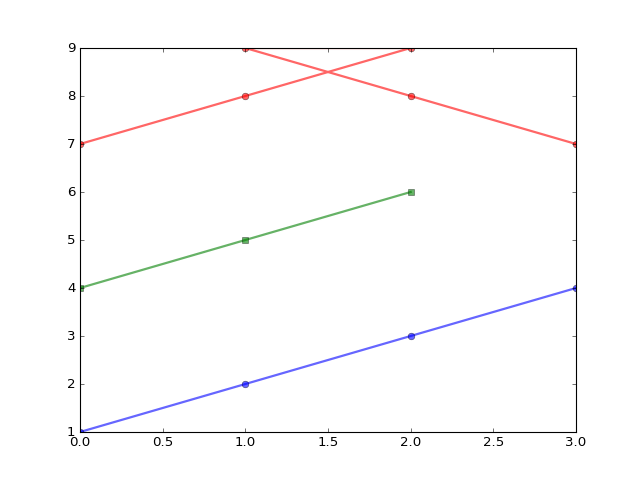

In [7]:
newplot()

In [8]:
plot(1)

In [9]:
plot([2,3,4])

In [10]:
plot([4,5,6], 'gs-')

In [11]:
plot([7,8,9], color='red')

In [12]:
plot([1,2,3], [9,8,7], color='red')

<IPython.core.display.Javascript object>


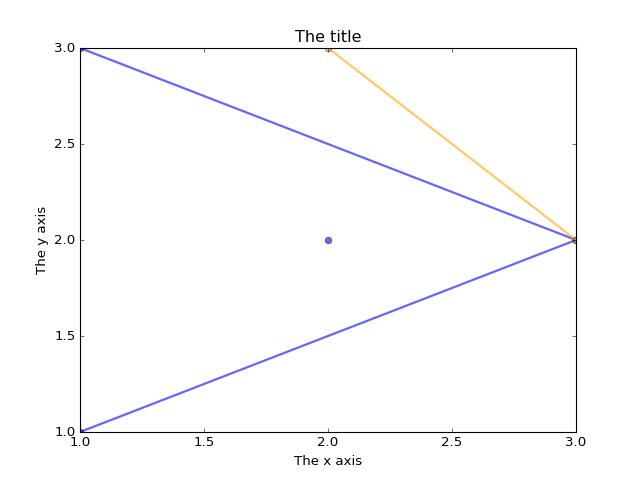

In [13]:
newplot()

In [14]:
plot(1, 1, 'bo-')

In [15]:
plot(2, 2, 'bo')

In [16]:
plot(3, 2, 'bo-')

In [17]:
plot(3, 2, color='orange')

In [18]:
plot(2, 3, color='orange')

In [19]:
plot(1, 3)

In [20]:
labels('The y axis', 'The x axis', 'The title')

<IPython.core.display.Javascript object>


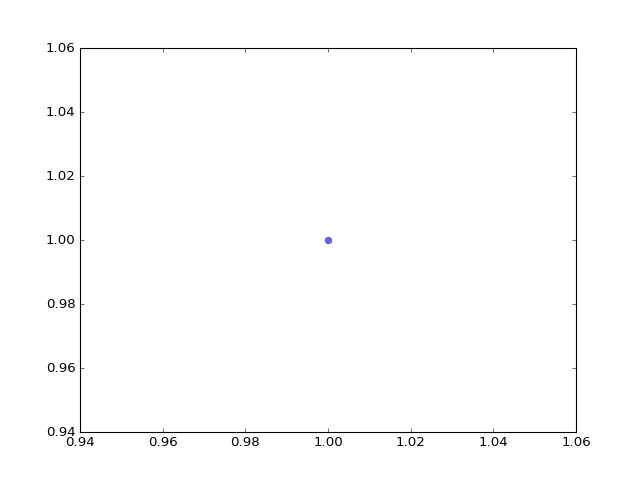

In [21]:
figure2 = newplot()

In [22]:
plot(1, 1)

<IPython.core.display.Javascript object>


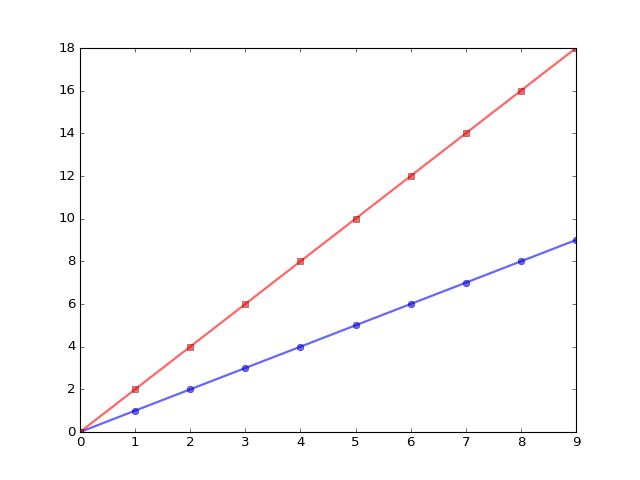

In [23]:
newplot()

for i in range(10):
    plot(i, i, 'bo-')
    plot(i, 2*i, 'rs-')

<IPython.core.display.Javascript object>


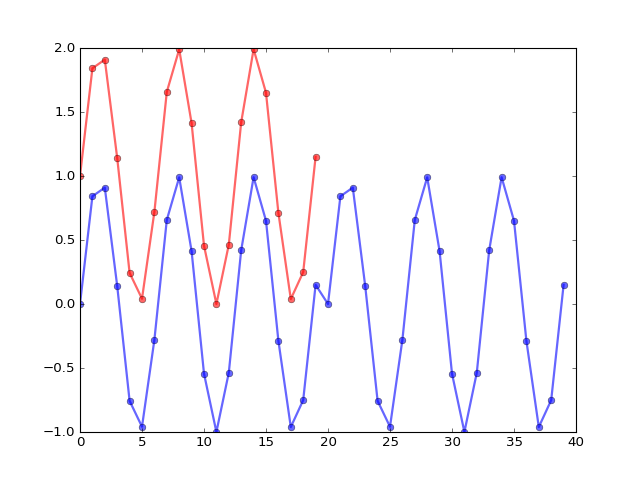

In [24]:
newplot()

In [25]:
xs = np.arange(20)
ys = np.sin(xs)
plot(xs, ys)

In [26]:
plot(xs, ys+1, color='red')

In [27]:
plot(xs+20, ys)

In [38]:
a = 150
b = 150

In [39]:
a_to_b = round(0.05 * a) - round(0.03 * b)

In [40]:
a -= a_to_b
b += a_to_b

In [42]:
a, b

(147.0, 153.0)

<IPython.core.display.Javascript object>


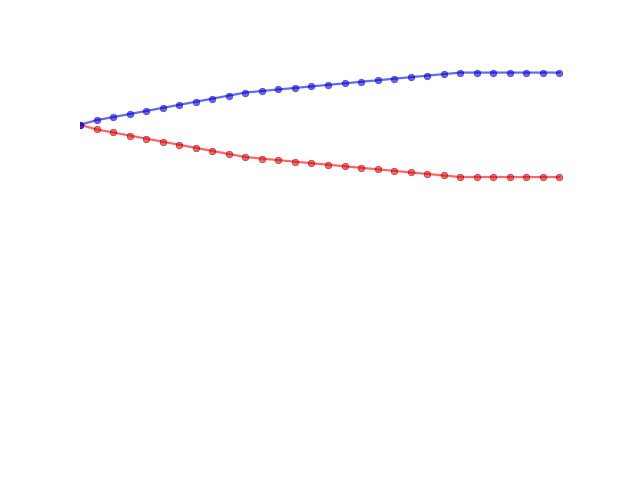

In [53]:
newplot()

a = 150
b = 150

for i in range(30):
    plot(i, a, color='red')
    plot(i, b, color='blue')
    a_to_b = round(0.05 * a) - round(0.03 * b)
    a -= a_to_b
    b += a_to_b

In [105]:
from pint import UnitRegistry
ureg = UnitRegistry()

In [111]:
import numpy as np
from scipy.integrate import odeint

def slope_func(Y, t):
    y, yp = Y
    ypp = -2*y - yp
    return yp, ypp

In [127]:
ts = np.arange(0, 15.0, 0.1) * (s)
ts

<Quantity([  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9], 'second')>

In [141]:
y_init = [1 * (m), 0 * (m/s)]
y_init

[<Quantity(1, 'meter')>, <Quantity(0, 'meter / second')>]

In [166]:
import pandas as pd

def ode_solve(slope_func, y_init, ts, columns=None):
    # if y0 has units, we have to strip them
    y0 = y_init[0]
    if isinstance(y0, ureg.Quantity):
        y_units = [y.units for y in y_init]
        y_mags = [y.magnitude for y in y_init]
    else:
        y_units = None
        y_mags = y_init
        
    # invoke the ODE solver
    asol = odeint(slope_func, y_mags, ts)
    
    # if there were units, put them back
    if y_units is not None:
        asol = asol * y_units
            
    # if column names were not provided, make them
    if columns is None:
        rows, cols = asol.shape
        columns = ['y%d'%i for i in range(cols)]

    # put the results into a DataFrame
    res = pd.DataFrame(data=asol, columns=columns, index=ts)
    
    return res

In [167]:
res = ode_solve(slope_func, y_init, ts)

In [177]:
res[0.7:0.8]

,y0,y1
0.7,0.636407931773 meter,-0.851490243511 meter / second
0.8,0.549500750053 meter,-0.883226789776 meter / second


In [170]:
newplot()
plot(res.y0, 'b')

<IPython.core.display.Javascript object>

AttributeError: 'Series' object has no attribute 'magnitude'

In [89]:
pd.DataFrame

In [107]:
m = ureg.meter
s = ureg.second

In [109]:
2 * (m) + 1 * (m)

<Quantity(3, 'meter')>

In [110]:
m/s * s

<Unit('meter')>